In [1]:
#LightGBM vs XGBoost
import warnings
warnings.filterwarnings("ignore")
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
#Load dataset
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

In [3]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [5]:
train_df.shape

(891, 12)

In [6]:
test_df.shape

(418, 11)

In [7]:
#Exploratory Data Analysis

In [8]:
#Missing values in training data:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

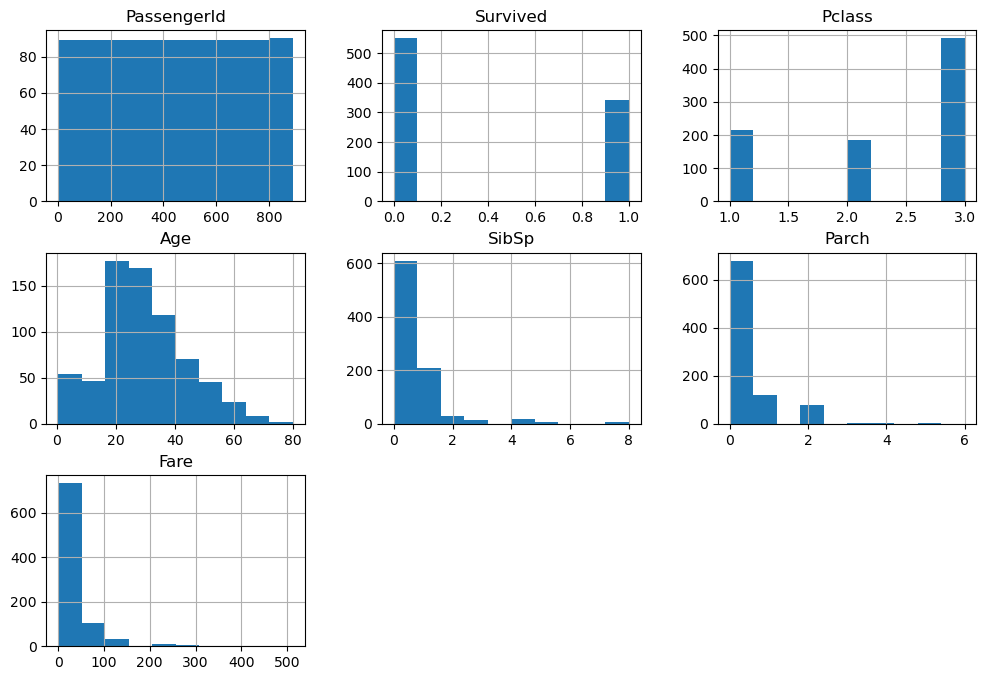

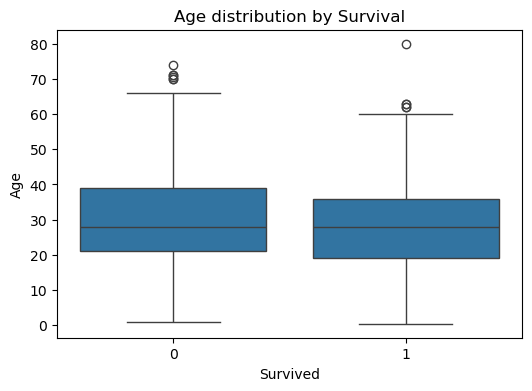

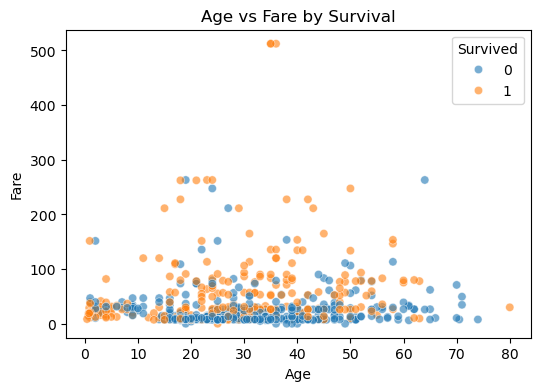

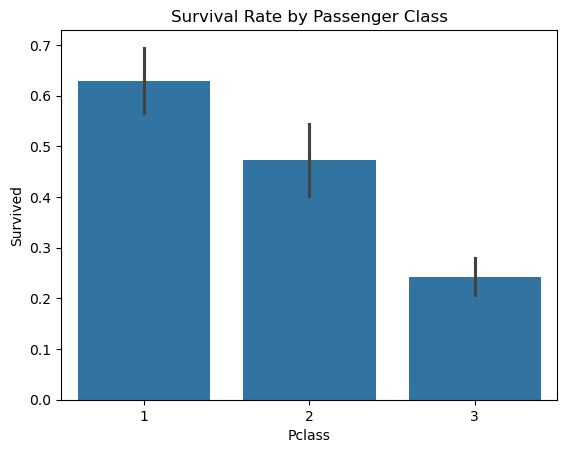

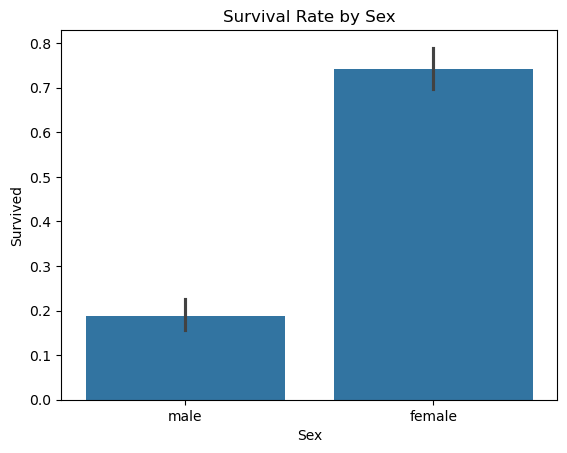

In [9]:
# Histogram of numerical features
train_df.hist(figsize=(12,8))
plt.show()
# Boxplot of Age
plt.figure(figsize=(6,4))
sns.boxplot(x="Survived", y="Age", data=train_df)
plt.title("Age distribution by Survival")
plt.show()
# Scatter plot: Age vs Fare with Survival
plt.figure(figsize=(6,4))
sns.scatterplot(x="Age", y="Fare", hue="Survived", data=train_df, alpha=0.6)
plt.title("Age vs Fare by Survival")
plt.show()
# Bar plot: Pclass vs Survival
sns.barplot(x="Pclass", y="Survived", data=train_df)
plt.title("Survival Rate by Passenger Class")
plt.show()
# Barplot for Sex vs Survival
sns.barplot(x="Sex", y="Survived", data=train_df)
plt.title("Survival Rate by Sex")
plt.show()

In [10]:
# Step 4: Data Preprocessing
def preprocess(df):
    df = df.copy() 
    # Fill missing Age with median
    df["Age"].fillna(df["Age"].median(), inplace=True)    
    # Fill missing Fare with median
    df["Fare"].fillna(df["Fare"].median(), inplace=True)  
    # Fill missing Embarked with mode
    df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)
    # Create new feature: FamilySize
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    # Drop useless columns
    drop_cols = ["PassengerId","Name","Ticket","Cabin"]
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)
    # Encode categorical variables
    cat_cols = df.select_dtypes(include=["object"]).columns
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])    
    return df

In [11]:
train_df_clean = preprocess(train_df)
test_df_clean = preprocess(test_df)

In [12]:
#After preprocessing
train_df_clean.shape

(891, 9)

In [13]:
#Split train/test
X = train_df_clean.drop("Survived", axis=1)
y = train_df_clean["Survived"]

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
#Build LightGBM model 
lgbm = LGBMClassifier(random_state=42) 
lgbm.fit(X_train, y_train) 
y_pred_lgbm = lgbm.predict(X_valid) 
#Build XGBoost model 
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42) 
xgb.fit(X_train, y_train) 
y_pred_xgb = xgb.predict(X_valid)

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [16]:
#Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nModel: {model_name}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


Model: LightGBM
Accuracy : 0.7932960893854749
Precision: 0.75
Recall   : 0.6956521739130435
F1-score : 0.7218045112781954

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



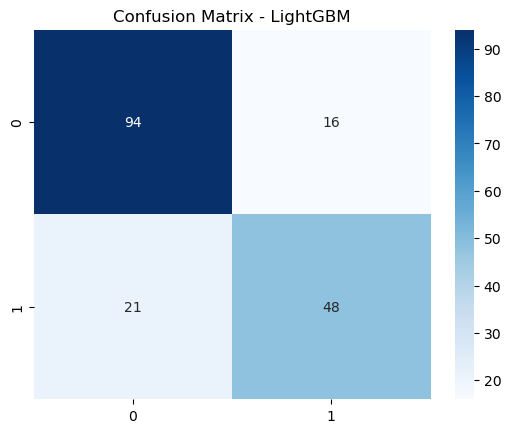


Model: XGBoost
Accuracy : 0.7932960893854749
Precision: 0.7352941176470589
Recall   : 0.7246376811594203
F1-score : 0.7299270072992701

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83       110
           1       0.74      0.72      0.73        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



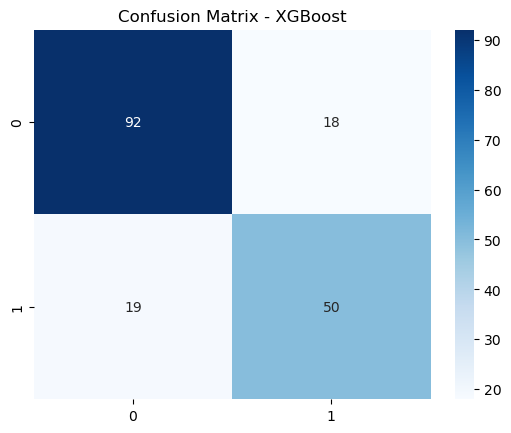

In [17]:
#Compare models
evaluate_model(y_valid, y_pred_lgbm, "LightGBM")
evaluate_model(y_valid, y_pred_xgb, "XGBoost")

In [18]:
# Comparative table of metrics
results = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost"],
    "Accuracy": [accuracy_score(y_valid, y_pred_lgbm), accuracy_score(y_valid, y_pred_xgb)],
    "Precision": [precision_score(y_valid, y_pred_lgbm), precision_score(y_valid, y_pred_xgb)],
    "Recall": [recall_score(y_valid, y_pred_lgbm), recall_score(y_valid, y_pred_xgb)],
    "F1-score": [f1_score(y_valid, y_pred_lgbm), f1_score(y_valid, y_pred_xgb)]
})

In [19]:
#Model Comparison Table
results

,Model,Accuracy,Precision,Recall,F1-score
0,LightGBM,0.793296,0.750000,0.695652,0.721805
1,XGBoost,0.793296,0.735294,0.724638,0.729927


In [20]:
#Conclusion
#Both LightGBM and XGBoost performed well.
#LightGBM is usually faster and requires less memory.
#XGBoost often gives slightly better accuracy after tuning.
#In practice, choice depends on dataset size and need for speed vs accuracy.